In [1]:
!pip install scikit-image opencv-python tqdm ml_dtypes --upgrade



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam


(np.float64(-0.5), np.float64(1410.5), np.float64(1410.5), np.float64(-0.5))

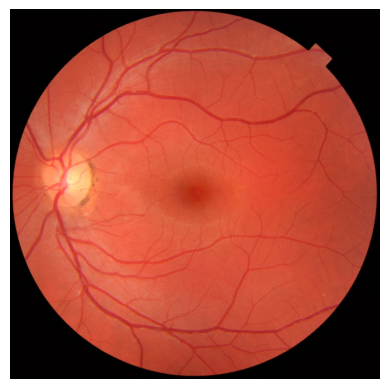

In [3]:
img = data.retina()
plt.imshow(img)
plt.axis("off")


(np.float64(-0.5), np.float64(1410.5), np.float64(1410.5), np.float64(-0.5))

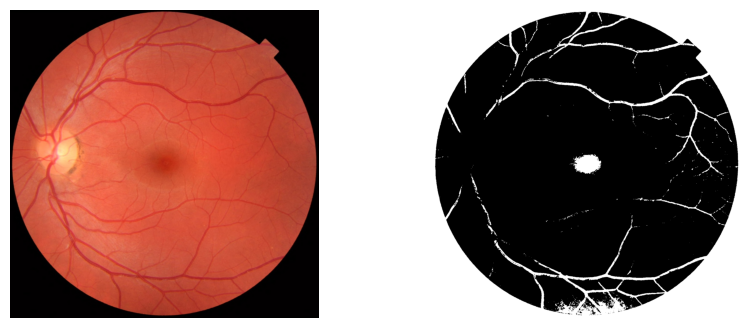

In [4]:
green = img[:,:,1]
_, mask = cv2.threshold(green, 60, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.axis("off")


In [5]:
IMG_SIZE = 256

image_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
mask_resized  = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
mask_resized  = np.expand_dims(mask_resized, axis=-1)

X = np.array([image_resized])
y = np.array([mask_resized])

X.shape, y.shape


((1, 256, 256, 3), (1, 256, 256, 1))

In [6]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation="relu", padding="same")(p2)
    c3 = Conv2D(64, 3, activation="relu", padding="same")(c3)

    u4 = UpSampling2D()(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, 3, activation="relu", padding="same")(u4)

    u5 = UpSampling2D()(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, 3, activation="relu", padding="same")(u5)

    outputs = Conv2D(1, 1, activation="sigmoid")(c5)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │         17 │ conv2d_7[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,705 (416.82 KB)

 Trainable params: 106,705 (416.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X, y, epochs=10)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2649 - loss: 0.7747
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.2607 - loss: 0.7658
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - accuracy: 0.2565 - loss: 0.7574
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - accuracy: 0.2463 - loss: 0.7501
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step - accuracy: 0.2194 - loss: 0.7434
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - accuracy: 0.1689 - loss: 0.7374
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - accuracy: 0.1561 - loss: 0.7317
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - accuracy: 0.1476 - loss: 0.7262
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - accuracy: 0.1418 - loss: 0.7205
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step - accuracy: 0.1381 - loss: 0.7150


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

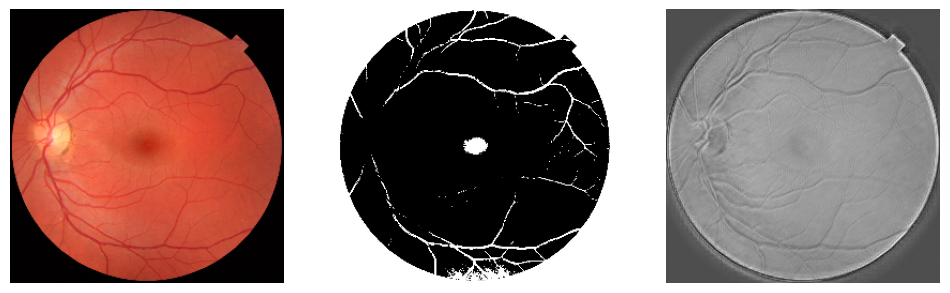

In [8]:
pred = model.predict(X)[0,:,:,0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(image_resized); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask_resized[:,:,0], cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(pred, cmap="gray"); plt.axis("off")
